In [77]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D
from keras.layers.core import Dense, Activation, Dropout, Flatten

model = Sequential()

model.add(SeparableConv2D(32, kernel_size=3, padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SeparableConv2D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SeparableConv2D(16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SeparableConv2D(8, kernel_size=5, padding='same', activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mae'])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', 'mae'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_24 (Separab (None, 32, 32, 32)        155       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
separable_conv2d_25 (Separab (None, 16, 16, 32)        1344      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
separable_conv2d_26 (Separab (None, 8, 8, 16)          816       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 4, 4, 16)          0         
_________________________________________________________________
separable_conv2d_27 (Separab (None, 4, 4, 8)          

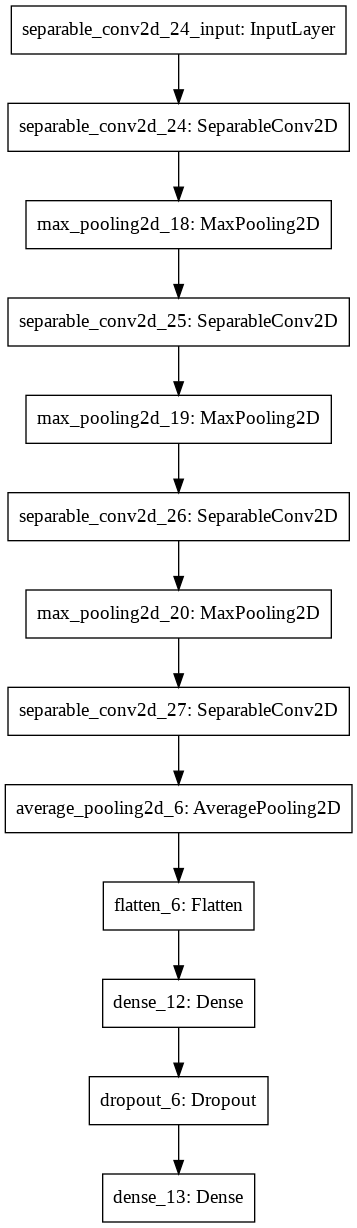

In [78]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

Image(model_to_dot(model).create(prog='dot', format='png'))

In [79]:
rm -rf `find -type d -name .ipynb_checkpoints`

In [80]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img
import os

trains_dirname = "dataset/labeled/trains"
valids_dirname = "dataset/labeled/valids"
trains_generator = ImageDataGenerator(
    rescale=1 / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    channel_shift_range=20.0,
    #shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )
valids_generator = ImageDataGenerator()

trains_generator = trains_generator.flow_from_directory(
    trains_dirname,
    target_size=(32,32),
    batch_size=32,
    class_mode='binary'
)
valids_generator = valids_generator.flow_from_directory(
    valids_dirname,
    target_size=(32,32),
    batch_size=32,
    class_mode='binary'
)

Found 4782 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


In [81]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

model_filename = os.path.join('models', 'finding-pikachu_model_{val_loss:.2f}.h5')

his=model.fit_generator(
    trains_generator,
    validation_data=valids_generator,
    steps_per_epoch=4782/32,
    epochs=20,
    callbacks = [
        TensorBoard(log_dir='tflogs'),
        #EarlyStopping(patience=3, monitor='val_loss'),
        ModelCheckpoint(model_filename, monitor='val_loss', save_best_only=True),
    ]
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
149/149 [==============================] - 11s 69ms/step - loss: 0.6807 - acc: 0.6101 - mae: 0.4903 - val_loss: 0.9032 - val_acc: 0.6250 - val_mae: 0.4299
Epoch 2/20
149/149 [==============================] - 10s 66ms/step - loss: 0.6321 - acc: 0.6312 - mae: 0.4491 - val_loss: 128.9016 - val_acc: 0.3750 - val_mae: 0.6250
Epoch 3/20
149/149 [==============================] - 10s 67ms/step - loss: 0.4420 - acc: 0.8002 - mae: 0.2947 - val_loss: 196.5381 - val_acc: 0.3750 - val_mae: 0.6250
Epoch 4/20
149/149 [==============================] - 10s 66ms/step - loss: 0.3457 - acc: 0.8506 - mae: 0.2253 - val_loss: 319.8738 - val_acc: 0.3750 - val_mae: 0.6250
Epoch 5/20
149/149 [==============================] - 10s 67ms/step - loss: 0.2325 - acc: 0.9024 - mae: 0.1546 - val_loss: 405.5139 - val_acc: 0.3750 - val_mae: 0.6250
Epoch 6/20
149/149 [==============================] - 10s 66ms/step - loss: 0.1501 - acc: 0.9476 - mae: 0.1000 - val_loss: 509.6325 - val_acc: 0.3750 - val_mae: 0

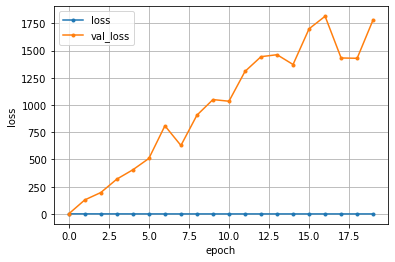

In [82]:
import matplotlib.pyplot as plt
loss = his.history['loss']
val_loss = his.history['val_loss']

epochs=20
# lossのグラフ
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

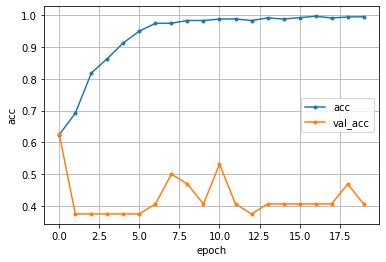

In [83]:
acc = his.history['acc']
val_acc = his.history['val_acc']

# accuracyのグラフ
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

In [84]:
import glob
import os
from keras.preprocessing.image import load_img, img_to_array
import shutil
import numpy as np



predicting_dirname = "dataset/reshaped/*"
predicted_dirname = "dataset/predicted_auto"
for i, file in enumerate(glob.glob(predicting_dirname)):
    image =load_img(file).resize((32, 32))
    array = img_to_array(image) / 255
    predicted = model.predict(np.array([
        array
    ]))
    prob = int(predicted[0][0]*100)
    print(f'file={file}, doraemon?={prob}%')
    
    if prob >= 90:
        shutil.copy(file, predicted_dirname)

file=dataset/reshaped/305.jpg, doraemon?=92%
file=dataset/reshaped/371.jpg, doraemon?=0%
file=dataset/reshaped/977.jpg, doraemon?=90%
file=dataset/reshaped/113.jpg, doraemon?=100%
file=dataset/reshaped/1258.jpg, doraemon?=99%
file=dataset/reshaped/824.jpg, doraemon?=0%
file=dataset/reshaped/993.jpg, doraemon?=0%
file=dataset/reshaped/209.jpg, doraemon?=3%
file=dataset/reshaped/867.jpg, doraemon?=0%
file=dataset/reshaped/865.jpg, doraemon?=99%
file=dataset/reshaped/342.jpg, doraemon?=0%
file=dataset/reshaped/1400.jpg, doraemon?=99%
file=dataset/reshaped/1467.jpg, doraemon?=0%
file=dataset/reshaped/87.jpg, doraemon?=0%
file=dataset/reshaped/909.jpg, doraemon?=0%
file=dataset/reshaped/1495.jpg, doraemon?=94%
file=dataset/reshaped/333.jpg, doraemon?=100%
file=dataset/reshaped/546.jpg, doraemon?=0%
file=dataset/reshaped/1293.jpg, doraemon?=0%
file=dataset/reshaped/507.jpg, doraemon?=2%
file=dataset/reshaped/949.jpg, doraemon?=4%
file=dataset/reshaped/512.jpg, doraemon?=100%
file=dataset/res